Premier League 2023–24 — Leakage-Free Round-by-Round Logistic Regression (Revised) Redesigned to prevent any post-match data leakage and compute rounds correctly in strict chronological order. Works on a single season even if the CSV is still being updated.

1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')


2. Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]
file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 22-23.csv"
df = pd.read_csv(file_path, usecols=usecols)

df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)
df.head()


Loaded shape: (380, 27)


,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Referee,HS,AS,HST,...,HR,AR,B365H,B365D,B365A,B365>2.5,B365<2.5,MatchIndex,Round,TimeOfDay
0,20:00,Crystal Palace,Arsenal,0,2,A,A Taylor,10,10,2,...,0,0,4.20,3.6,1.85,2.10,1.72,1,1,Evening
1,12:30,Fulham,Liverpool,2,2,D,A Madley,9,11,3,...,0,0,11.00,6.0,1.25,1.50,2.62,2,1,Afternoon
2,15:00,Bournemouth,Aston Villa,2,0,H,P Bankes,7,15,3,...,0,0,3.75,3.5,2.00,2.00,1.80,3,1,Afternoon
3,15:00,Leeds,Wolves,2,1,H,R Jones,12,15,4,...,0,0,2.25,3.4,3.20,2.05,1.85,4,1,Afternoon
4,15:00,Newcastle,Nott'm Forest,2,0,H,S Hooper,23,5,10,...,0,0,1.66,3.8,5.25,2.05,1.85,5,1,Afternoon


3. Leakage-Free Feature Engineering
Compute all features using only prior data, never peeking at the current match’s outcome or post-match stats.

In [3]:
# 3.1 Targets
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from odds
for side in ['H','D','A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H','ImpProb_D','ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5','ImpUnder2.5']] = (
    df[['ImpOver2.5','ImpUnder2.5']]
      .div(df[['ImpOver2.5','ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form (shift so we use only past matches)
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/Loss streaks (shifted)
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: 
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: 
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias (shifted cumulative)
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins','RefMatches'], inplace=True)

# 3.8 Head-to-head last result
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# 3.9 Rolling averages of match stats (shots, fouls, cards)
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# 3.10 Previous-round table positions

# compute home/away points for each match
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

# stack into long format: Team, Round, Pts
pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],   df['AwayPts']])
})

# sum points by Team & Round, then compute cumulative points
round_pts = (
    pts
    .groupby(['Team','Round'], as_index=False)['Pts']
    .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()

# rank positions within each round
round_pts['Pos'] = (
    round_pts
    .groupby('Round')['CumPts']
    .rank(method='min', ascending=False)
)

# prepare lookup: for each team, which position did they have in the previous round?
prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

# merge to get HomePosPrev
df = df.merge(
    prev,
    left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'],
    how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# merge to get AwayPosPrev
df = df.merge(
    prev,
    left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'],
    how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

# categorical features
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

# numeric features
num_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread',
    'Spread×Form','HomeForm3','AwayForm3',
    'HomeStreak','AwayStreak','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev',
    'Home_HS_3','Home_HST_3','Home_HF_3','Home_HC_3','Home_HY_3','Home_HR_3',
    'Away_AS_3','Away_AST_3','Away_AF_3','Away_AC_3','Away_AY_3','Away_AR_3'
]



4. Pipeline Specification

In [4]:
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.stats import loguniform, uniform

# 4.1) categorical & numeric preprocess (sparse-friendly)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=True))
])

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='constant', fill_value=0)),
    ('scale', MaxAbsScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipe, cat_feats),
        ('num', num_pipe, num_feats)
    ],
    sparse_threshold=1.0  # keep sparse matrices end-to-end
)

# 4.2) multinomial logistic regression (elastic-net, balanced)
def make_lr_pipeline():
    return Pipeline(steps=[
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='saga',
            multi_class='multinomial',
            penalty='elasticnet',
            l1_ratio=0.1,             # small L1 by default (tuned below)
            C=1.0,                    # tuned below
            class_weight='balanced',
            max_iter=1000,
            random_state=42,
            n_jobs=-1
        ))
    ])

# 4.3) time-series CV + multi-metric search (compromise)
tscv = TimeSeriesSplit(n_splits=3)
scorers = {'bal_acc': 'balanced_accuracy', 'acc': 'accuracy'}

param_distributions = {
    'clf__C'        : loguniform(1e-3, 1e2),
    'clf__l1_ratio' : uniform(0.0, 0.5)    # 0..0.5
}

def make_rand_search_lr():
    return RandomizedSearchCV(
        estimator=make_lr_pipeline(),
        param_distributions=param_distributions,
        n_iter=40,                 # reduce to 20 if you need speed
        cv=tscv,
        scoring=scorers,           # tune on both
        refit='bal_acc',           # select by balanced accuracy
        n_jobs=-1,
        random_state=42,
        verbose=0
    )


5. Round-by-Round Training & Prediction

In [5]:
from sklearn.metrics import accuracy_score
import numpy as np

# 5.1) containers
preds, actuals, rounds, match_indices = [], [], [], []

# 5.2) warm-up: first 5 rounds (~10 matches/round), no tuning
WARMUP_ROUNDS  = 5
WARMUP_MATCHES = WARMUP_ROUNDS * 10

X_warm = df.loc[:WARMUP_MATCHES-1, cat_feats + num_feats]
y_warm = df.loc[:WARMUP_MATCHES-1, 'Outcome']

# simple warm-up fit (not used for prediction later; avoids cold start)
_ = make_lr_pipeline().fit(X_warm, y_warm)

# 5.3) predict from round 6 onward (always 10 matches per round)
max_round = int(df['Round'].max())
for r in range(WARMUP_ROUNDS + 1, max_round + 1):
    train_mask = df['Round'] < r
    test_mask  = df['Round'] == r

    # build training slice
    X_train = df.loc[train_mask, cat_feats + num_feats]
    y_train = df.loc[train_mask, 'Outcome']

    # build test slice, enforce exactly 10 matches
    round_df = df.loc[test_mask, :].sort_values(['Round', 'MatchIndex'])
    if len(round_df) > 10:
        round_df = round_df.head(10)
    if len(round_df) < 10:
        print(f"Round {r}: only {len(round_df)} matches available → skipped.")
        continue

    X_test = round_df[cat_feats + num_feats]
    y_test = round_df['Outcome']

    # randomized search (time-series CV, multi-metric)
    rs = make_rand_search_lr()
    rs.fit(X_train, y_train)
    model = rs.best_estimator_

    # predict exactly 10 matches
    y_pred = model.predict(X_test)

    # collect results
    preds.extend(np.asarray(y_pred).ravel().tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))               # always 10
    match_indices.extend(round_df['MatchIndex'].tolist())

    # per-round accuracy (report only accuracy)
    acc = accuracy_score(y_test, y_pred)
    best = rs.best_params_
    print(f"Round {r}: 10 matches | accuracy = {acc:.3f} | "
          f"C={best.get('clf__C'):.4f}, l1_ratio={best.get('clf__l1_ratio'):.2f}")

print(f"Predicted rounds {WARMUP_ROUNDS + 1}–{max_round} (10 matches each)")

# 5.4) expose final trained model and last training round
final_model = model
last_train_round = max_round - 1


Round 6: 10 matches | accuracy = 0.400 | C=0.0333, l1_ratio=0.05
Round 7: 10 matches | accuracy = 0.300 | C=0.1907, l1_ratio=0.39
Round 8: 10 matches | accuracy = 0.400 | C=0.1445, l1_ratio=0.15


c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 9: 10 matches | accuracy = 0.300 | C=1.0129, l1_ratio=0.35
Round 10: 10 matches | accuracy = 0.500 | C=0.0620, l1_ratio=0.06
Round 11: 10 matches | accuracy = 0.500 | C=0.1907, l1_ratio=0.39
Round 12: 10 matches | accuracy = 0.300 | C=0.1445, l1_ratio=0.15
Round 13: 10 matches | accuracy = 0.500 | C=1.1462, l1_ratio=0.07
Round 14: 10 matches | accuracy = 0.400 | C=0.0620, l1_ratio=0.06
Round 15: 10 matches | accuracy = 0.700 | C=0.0878, l1_ratio=0.14
Round 16: 10 matches | accuracy = 0.800 | C=0.0878, l1_ratio=0.14
Round 17: 10 matches | accuracy = 0.400 | C=0.0333, l1_ratio=0.05
Round 18: 10 matches | accuracy = 0.400 | C=0.0620, l1_ratio=0.06
Round 19: 10 matches | accuracy = 0.500 | C=0.0620, l1_ratio=0.06
Round 20: 10 matches | accuracy = 0.600 | C=0.0878, l1_ratio=0.14
Round 21: 10 matches | accuracy = 0.400 | C=0.1445, l1_ratio=0.15
Round 22: 10 matches | accuracy = 0.500 | C=0.1445, l1_ratio=0.15
Round 23: 10 matches | accuracy = 0.200 | C=0.1445, l1_ratio=0.15
Round 24: 1

c:\Users\markf\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Round 26: 10 matches | accuracy = 0.300 | C=0.9761, l1_ratio=0.46
Round 27: 10 matches | accuracy = 0.500 | C=0.0333, l1_ratio=0.05
Round 28: 10 matches | accuracy = 0.600 | C=0.0333, l1_ratio=0.05
Round 29: 10 matches | accuracy = 0.700 | C=0.1907, l1_ratio=0.39
Round 30: 10 matches | accuracy = 0.400 | C=0.1907, l1_ratio=0.39
Round 31: 10 matches | accuracy = 0.300 | C=0.1907, l1_ratio=0.39
Round 32: 10 matches | accuracy = 0.600 | C=0.1907, l1_ratio=0.39
Round 33: 10 matches | accuracy = 0.600 | C=0.1907, l1_ratio=0.39
Round 34: 10 matches | accuracy = 0.900 | C=0.1907, l1_ratio=0.39
Round 35: 10 matches | accuracy = 0.400 | C=0.1445, l1_ratio=0.15
Round 36: 10 matches | accuracy = 0.800 | C=0.0620, l1_ratio=0.06
Round 37: 10 matches | accuracy = 0.500 | C=0.1445, l1_ratio=0.15
Round 38: 10 matches | accuracy = 0.600 | C=13.9215, l1_ratio=0.18
Predicted rounds 6–38 (10 matches each)


6. Assemble & Save Results

In [6]:
df_idx = df.set_index('MatchIndex')
homes = [df_idx.loc[i, 'HomeTeam'] for i in match_indices]
aways = [df_idx.loc[i, 'AwayTeam'] for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

output_path = r"D:\python\premier league predictor\predictions_vs_actuals.xlsx"
results_df.to_excel(output_path, index=False)
print("Results written to", output_path)


Results written to D:\python\premier league predictor\predictions_vs_actuals.xlsx


7. Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_15888\1585225667.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: accuracy_score(g['True'], g['Pred']))


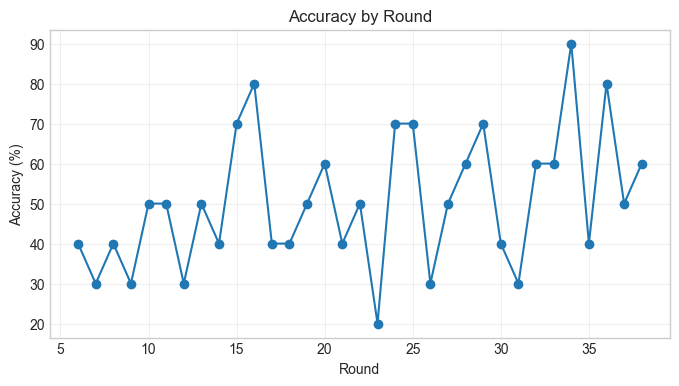

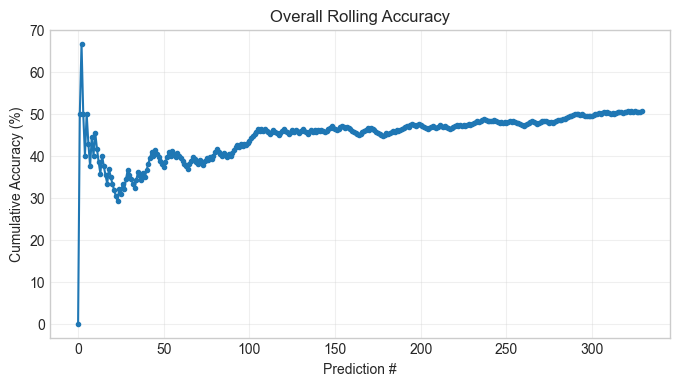

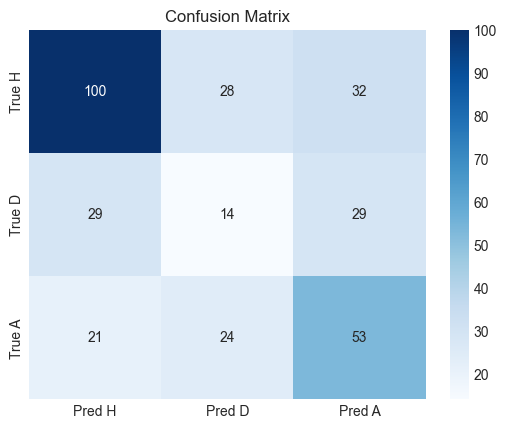


Overall accuracy (rounds 6–38): 0.506
Text summary: The model achieved an overall accuracy of 50.6% across rounds 6–38.


In [7]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

# round-by-round accuracy
res = pd.DataFrame({'Round': rounds, 'Pred': preds, 'True': actuals})
round_acc = res.groupby('Round') \
               .apply(lambda g: accuracy_score(g['True'], g['Pred']))

plt.figure(figsize=(8,4))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.show()

# cumulative accuracy
cum_acc = np.cumsum(np.array(preds) == np.array(actuals)) / np.arange(1, len(preds) + 1)
plt.figure(figsize=(8,4))
plt.plot(cum_acc * 100, marker='.')
plt.xlabel('Prediction #')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Overall Rolling Accuracy')
plt.grid(alpha=0.3)
plt.show()

# confusion matrix
cm = confusion_matrix(actuals, preds, labels=[1,0,-1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred H','Pred D','Pred A'],
            yticklabels=['True H','True D','True A'])
plt.title('Confusion Matrix')
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

8. Gradio Interface

In [8]:
import gradio as gr
import pandas as pd
import numpy as np

# ----------------------------------------------------------------------------
# Precompute the training-set means of the odds-derived features:
# ----------------------------------------------------------------------------
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# ----------------------------------------------------------------------------
# Gradio dropdown choices:
# ----------------------------------------------------------------------------
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# ----------------------------------------------------------------------------
# Prediction function
# ----------------------------------------------------------------------------
def predict_outcome(home_team, away_team, referee, time_of_day):
    # 1) Pull the last historical row for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee == referee].iloc[-1]
    
    # 2) Assemble the feature dict
    data = {}
    
    # 2a) Odds-derived features: fill with their training-set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    
    # 2b) Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    
    # 2c) Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    
    # 2d) Referee bias
    data['RefBias'] = ref['RefBias']
    
    # 2e) Head-to-head last
    pair = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[pair].iloc[-1]['H2H_Last']
    
    # 2f) Previous round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    
    # 2g) Rolling match-stats (shots, fouls, cards)
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    
    # 2h) Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # 3) DataFrame and predict
    Xnew  = pd.DataFrame([data])
    probs = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # e.g. [-1,0,1]
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# ----------------------------------------------------------------------------
# Launch Gradio interface
# ----------------------------------------------------------------------------
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds-derived features are filled with their historical averages, "
        "all other features are pulled from past matches."
    )
)

iface.launch()


* Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.
